In [84]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio
from parameters.parameters import Parameters as params
## analysis imports
from analysis.dately_analysis import DatelyAnalysis as dately_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class
from fund.fund import Fund

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [85]:
backtest_start_date = datetime(2001,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [86]:
market = Market()

In [87]:
portfolio = APortfolio(pricer_list.DAILY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_ii = APortfolio(pricer_list.DAILY_STOCK_ROLLING
                           ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iii = APortfolio(pricer_list.DAILY_STOCK_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)

portfolios = []
portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)

In [88]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [89]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [90]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

Index(['realtime_start', 'realtime_end', 'date', 'adjclose', 'year', 'quarter',
       'week', 'day', 'bench_dately_return', 'bench_weekly_return'],
      dtype='object') Index(['year', 'quarter', 'quarter_start'], dtype='object')


In [91]:
analysis = []
parameters = params.parameters()
indexer = list(parameters[0].keys()) + ['portfolio']
indexer
for portfolio in tqdm(portfolios):
    portfolio.db.connect()
    for parameter in tqdm(parameters):
        try:
            trade = portfolio.db.query("trades",parameter)
            if trade.index.size > 0:
                indexer = list(parameters[0].keys()) + ['portfolio']
                positions = int(portfolio.pricer_class.positions / 10) if portfolio.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  portfolio.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = weekly_analysis if pricer_timeframe == "week" else dately_analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["portfolio"] = portfolio.name
                    analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    portfolio.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 26/27 [06:11<00:27, 27.55s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [16:41<00:00, 333.88s/it]


In [92]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,tyields,portfolio,pv,beta,rrr,sharpe
47,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields10,dsw_n_n_b_r,9.555659,-0.216622,1.013816,-39.495496
46,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields2,dsw_n_n_b_r,9.555659,-0.216622,1.013816,-39.495496
45,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields,dsw_n_n_b_r,9.555659,-0.216622,1.013816,-39.495496
7,True,True,False,False,False,1.15,5,1,rrr,0.5,tyields2,dss_n_n_b_r,9.523146,0.225942,0.975567,37.722498
11,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields10,dss_n_n_b_r,9.523146,0.225942,0.975567,37.722498
9,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields,dss_n_n_b_r,9.523146,0.225942,0.975567,37.722498
8,True,True,False,False,False,1.15,5,1,rrr,0.5,tyields10,dss_n_n_b_r,9.523146,0.225942,0.975567,37.722498
10,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields2,dss_n_n_b_r,9.523146,0.225942,0.975567,37.722498
6,True,True,False,False,False,1.15,5,1,rrr,0.5,tyields,dss_n_n_b_r,9.523146,0.225942,0.975567,37.722498
42,True,True,False,False,False,1.15,5,1,rrr,0.5,tyields,dsw_n_n_b_r,9.317782,-0.212735,1.013569,-39.099052


In [93]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,tyields,pv,beta,rrr,sharpe
0,dsr_n_n_b_r,True,True,False,False,False,1.15,5,1,flat,0.5,tyields10,3.163563,-0.271316,1.017367,-7.974139
1,dss_n_n_b_r,True,True,False,False,False,1.15,5,1,rrr,0.5,tyields2,9.523146,0.225942,0.975567,37.722498
2,dsw_n_n_b_r,True,True,False,False,False,1.15,5,1,rrr,1.0,tyields10,9.555659,-0.216622,1.013816,-39.495496


In [115]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["portfolio"])
parameter = top[[x for x in indexer if x != "portfolio"]].to_dict()
parameter
db.connect()
analysis = db.query("trades",parameter)
db.disconnect()

In [116]:
anas = dately_analysis
naming = "date"
positions = int(int(analysis["position"].max())/5)
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [117]:
ledger

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,TPR,0.267478,1.0,0.997321,0,Consumer Discretionary,"Tapestry, Inc."
1,2001,2001-01-03,TTWO,0.189982,1.0,1.016889,0,Communication Services,Take-Two Interactive
2,2001,2001-01-04,KLAC,0.278285,1.0,0.934187,0,Information Technology,KLA Corporation
3,2001,2001-01-05,BBY,0.359261,1.0,0.940411,0,Consumer Discretionary,Best Buy
4,2001,2001-01-08,BBY,0.395844,1.0,1.071619,0,Consumer Discretionary,Best Buy
...,...,...,...,...,...,...,...,...,...
231529,2013,2013-06-26,ALB,0.005305,1.0,1.001436,99,Materials,Albemarle Corporation
231530,2013,2013-06-28,NLOK,0.012853,1.0,0.999778,99,Information Technology,NortonLifeLock
231531,2013,2013-07-02,FITB,0.000129,1.0,0.994048,99,Financials,Fifth Third Bank
231532,2013,2013-07-03,CRM,0.013623,1.0,1.010117,99,Information Technology,Salesforce


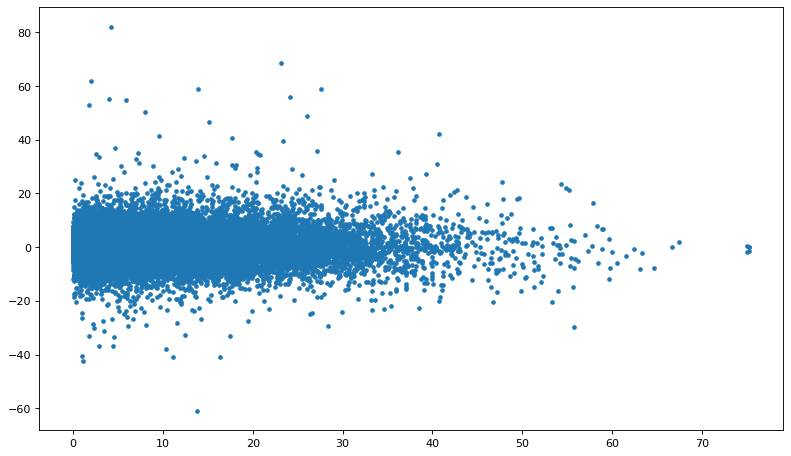

In [118]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [119]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,TPR,0.267478,1.0,0.997321,0,Consumer Discretionary,"Tapestry, Inc."
3118,2001,2001-01-02,DVA,0.241097,1.0,1.097758,1,Health Care,DaVita Inc.
6235,2001,2001-01-02,WAB,0.217872,1.0,1.000000,2,Industrials,Wabtec
9340,2001,2001-01-02,PAYX,0.198026,1.0,1.064347,3,Information Technology,Paychex
12442,2001,2001-01-02,GS,0.189055,1.0,1.151545,4,Financials,Goldman Sachs
15536,2001,2001-01-02,CTRA,0.178262,1.0,1.006538,5,Energy,Coterra
18618,2001,2001-01-02,ORLY,0.177570,1.0,1.061526,6,Consumer Discretionary,O'Reilly Auto Parts
21689,2001,2001-01-02,TTWO,0.168435,1.0,1.034007,7,Communication Services,Take-Two Interactive
24743,2001,2001-01-02,ISRG,0.162353,1.0,1.072304,8,Health Care,Intuitive Surgical
27785,2001,2001-01-02,CCL,0.162285,1.0,1.068527,9,Consumer Discretionary,Carnival


In [120]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
11223,2008,2008-07-21,UAL,0.231193,1.0,1.685371,3,Industrials,United Airlines Holdings
23745,2009,2009-05-07,FITB,0.276241,1.0,1.588103,7,Financials,Fifth Third Bank
41693,2008,2008-07-21,AAL,0.139373,1.0,1.587361,13,Industrials,American Airlines Group
19090,2002,2002-11-27,SEE,0.241964,1.0,1.560458,6,Materials,Sealed Air
5178,2009,2009-04-08,TXT,0.260532,1.0,1.488474,1,Industrials,Textron
8160,2008,2008-09-18,ZION,0.151709,1.0,1.467908,2,Financials,Zions Bancorporation
5093,2008,2008-12-04,LNC,0.407618,1.0,1.421785,1,Financials,Lincoln Financial
49281,2003,2003-05-16,REGN,0.095172,1.0,1.415014,16,Health Care,Regeneron
28236,2002,2002-10-30,AES,0.233871,1.0,1.393701,9,Utilities,AES Corporation
9421,2001,2001-04-30,BKNG,0.271429,1.0,1.358763,3,Consumer Discretionary,Booking Holdings


In [121]:
ledger["actual_returns"].mean()

1.0006074074461981

In [122]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.504928001934921

In [123]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [124]:
portfolio

position,year,date,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,2001,2001-01-02,0.997321,1.097758,1.000000,1.064347,1.151545,1.006538,1.061526,1.034007,...,1.035153,0.995862,0.927314,1.024955,1.011395,0.961774,1.000000,0.944221,1.173182,1.091241
1,2001,2001-01-03,1.016889,1.016889,0.976623,1.025742,0.946682,0.954363,1.049583,1.022019,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2001,2001-01-04,0.934187,1.039022,0.966064,0.961920,1.000000,0.918907,1.085455,0.883390,...,1.017699,0.987814,0.993026,0.983959,0.967208,0.965134,0.989423,1.007825,0.984364,0.939123
3,2001,2001-01-05,0.940411,0.906977,1.000000,1.095444,1.085776,1.002070,0.967742,0.953098,...,0.995319,1.002832,1.023288,0.994278,1.015094,0.930723,0.995922,0.990099,1.061739,1.014681
4,2001,2001-01-08,1.071619,1.160256,0.982875,1.019936,0.913223,1.000000,1.027737,1.041333,...,1.005736,1.011460,0.991010,1.046599,1.000000,0.989333,1.042827,1.012739,0.951795,1.072798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,2013,2013-06-28,0.993532,0.995813,0.956066,1.019107,0.947756,1.016081,1.091459,1.010291,...,0.977575,0.981865,0.978563,1.019569,1.014874,1.020569,1.006591,1.008678,1.010499,0.999778
3114,2013,2013-07-01,0.953125,0.985245,0.993709,1.007352,1.002803,1.008214,0.962895,1.014235,...,0.989748,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3115,2013,2013-07-02,0.978102,1.015027,0.999766,1.005782,0.998417,1.000160,1.002632,1.006110,...,1.003657,0.999083,1.001057,0.996299,1.004203,1.000225,0.994030,1.006371,1.012329,0.994048
3116,2013,2013-07-03,1.023326,1.042086,1.009421,1.036585,1.025099,1.043112,1.049869,1.040068,...,1.011545,1.006029,1.007261,1.024038,1.005523,1.020049,1.012409,0.988200,1.019738,1.010117


In [148]:
positions = 10

In [149]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [150]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,year,date,pv,daily_returns,adjclose,bench
3108,2.873004,0.210235,1.896504,17.236695,49.046662,0.400265,4.698166,0.552677,0.251194,15.540866,2013,2013-06-21,9.270627,0.989297,1592.430054,1.240916
3109,2.777704,0.217609,1.937365,17.562560,48.770868,0.412735,4.613206,0.555002,0.253494,15.882074,2013,2013-06-24,9.298262,1.008512,1573.089966,1.225845
3110,2.777350,0.218896,2.000178,17.808140,49.278561,0.425492,4.608978,0.569419,0.252530,15.885837,2013,2013-06-25,9.382538,1.011501,1588.030029,1.237487
3111,2.796589,0.238767,2.023460,17.870131,51.175494,0.428884,4.604580,0.587347,0.248972,15.655608,2013,2013-06-26,9.562983,1.016124,1603.260010,1.249355
3112,2.792484,0.238600,2.044890,17.560982,50.764251,0.426962,4.606068,0.588664,0.246332,15.529490,2013,2013-06-27,9.479872,0.996251,1613.199951,1.257101
3113,2.774422,0.237601,1.955050,17.896527,48.112108,0.433827,5.027333,0.594722,0.251760,15.585306,2013,2013-06-28,9.286866,1.005573,1606.280029,1.251709
3114,2.644371,0.234095,1.942751,18.028096,48.246970,0.437391,4.840793,0.603187,0.257775,15.392803,2013,2013-07-01,9.262823,0.993912,1614.959961,1.258472
3115,2.586465,0.237613,1.942296,18.132327,48.170610,0.437461,4.853532,0.606873,0.259959,15.376035,2013,2013-07-02,9.260317,1.001338,1614.079956,1.257787
3116,2.646797,0.247613,1.960595,18.795705,49.379648,0.456321,5.095572,0.631189,0.262505,15.498640,2013,2013-07-03,9.497458,1.028733,1615.410034,1.258823
3117,2.680298,0.264451,1.967675,18.919509,49.861319,0.458149,5.057355,0.633133,0.261733,15.452966,2013,2013-07-05,9.555659,1.009431,1619.090000,1.261691


In [151]:
cumulative["previous_day"] = cumulative["daily_returns"].shift(1)
cumulative["base"] = [min(row[1]["previous_day"],1) for row in cumulative.iterrows()]
cumulative["real_return"] = cumulative["base"] * cumulative["daily_returns"]
cumulative["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cumulative.iterrows()]

In [152]:
cumulative["cash"].sum()

1709.3052173990382

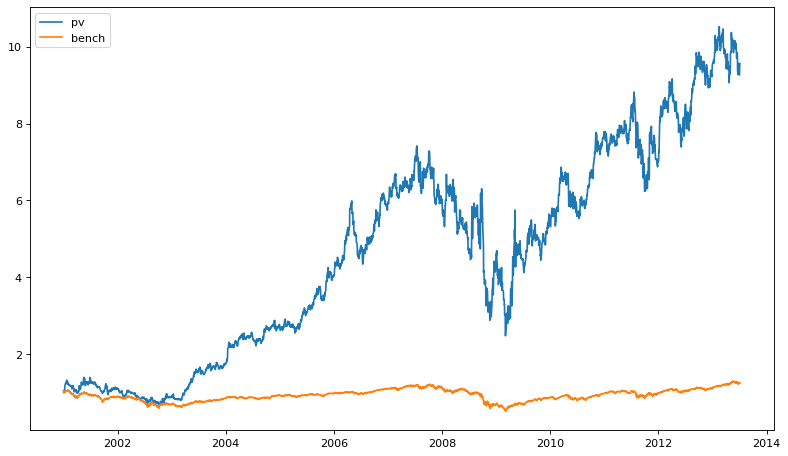

In [153]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [131]:
cumulative.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,year,date,pv,daily_returns,adjclose,bench,previous_day,base,real_return,cash
3098,2.857632,0.221958,1.999389,19.320729,53.693706,0.411199,4.439616,0.577392,0.259937,17.088330,...,2013,2013-06-07,7.146018,1.002068,1643.380005,1.280619,1.015412,1.000000,1.002068,0.206847
3099,2.833365,0.213292,1.988375,19.037449,53.104475,0.403073,4.330573,0.563360,0.255398,16.538882,...,2013,2013-06-10,7.022439,0.981973,1642.810059,1.280175,1.002068,1.000000,0.981973,0.000000
3100,2.751689,0.212968,1.938549,18.658013,52.863011,0.401037,4.271710,0.558548,0.259445,16.557536,...,2013,2013-06-11,6.966260,0.990568,1626.130005,1.267177,0.981973,0.981973,0.972711,0.000000
3101,2.792971,0.212219,1.951590,18.444057,51.974355,0.414556,4.381636,0.559805,0.269108,16.875870,...,2013,2013-06-12,6.945326,1.014872,1612.520020,1.256571,0.990568,0.990568,1.005299,0.529912
3102,2.800114,0.209285,1.928915,18.481373,51.380979,0.417498,4.339222,0.556151,0.263067,16.588721,...,2013,2013-06-13,6.883304,0.992542,1636.359985,1.275149,1.014872,1.000000,0.992542,0.000000
3103,2.905447,0.215201,1.929927,18.674505,52.177034,0.418440,4.507914,0.567663,0.266528,16.697458,...,2013,2013-06-14,6.970259,1.012655,1626.729980,1.267644,0.992542,0.992542,1.005102,0.510233
3104,2.916118,0.223491,1.952412,18.891947,51.705401,0.421440,4.528379,0.570822,0.267856,16.932220,...,2013,2013-06-17,6.994956,1.012322,1639.040039,1.277237,1.012655,1.000000,1.012322,1.232200
3105,2.962775,0.219673,1.937331,18.891947,50.513525,0.417261,4.584880,0.562567,0.264953,16.743917,...,2013,2013-06-18,6.907426,0.993229,1651.810059,1.287188,1.012322,1.000000,0.993229,0.000000
3106,2.870520,0.211060,1.966151,18.056337,48.994024,0.406861,4.729253,0.543851,0.257405,15.718452,...,2013,2013-06-19,6.703231,0.975525,1628.930054,1.269359,0.993229,0.993229,0.968919,0.000000
3107,2.947930,0.212253,1.958500,17.793205,48.994024,0.402189,4.706566,0.537907,0.257838,15.624853,...,2013,2013-06-20,6.689906,1.001779,1588.189941,1.237612,0.975525,0.975525,0.977261,0.000000


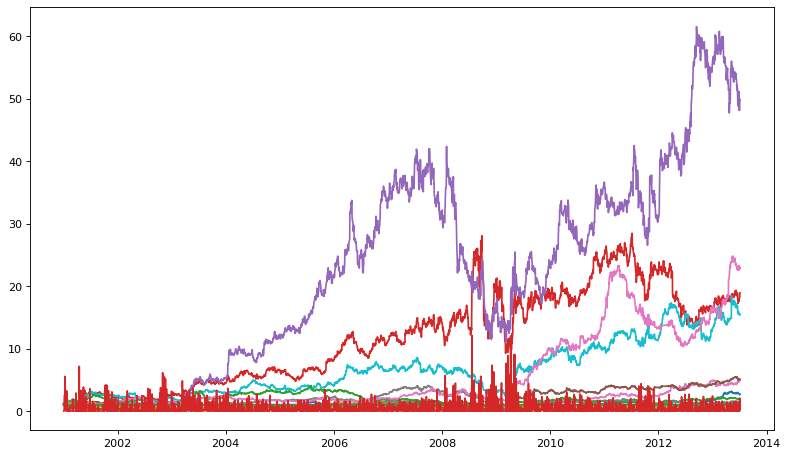

In [132]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [133]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Real Estate,2006.870035,0.054174,1.0,1.001419,45.469021
Materials,2006.838811,0.049952,1.0,1.001068,45.676132
Utilities,2006.235435,0.038384,1.0,1.000749,48.967377
Energy,2006.796832,0.052720,1.0,1.000735,39.549480
Consumer Staples,2006.655368,0.038777,1.0,1.000656,45.497554
Consumer Discretionary,2006.798430,0.059806,1.0,1.000636,39.941640
Health Care,2006.539556,0.053920,1.0,1.000628,40.263784
Industrials,2006.606602,0.051672,1.0,1.000628,45.950900
Financials,2006.977903,0.052735,1.0,1.000339,47.469933


In [134]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

dately_delta  \
year date       ticker Security                                      
2008 2008-09-18 RF     Regions Financial Corporation      0.042648   
     2008-07-21 UAL    United Airlines Holdings           0.231193   
2013 2013-04-18 VRTX   Vertex Pharmaceuticals             0.020261   
2009 2009-05-07 FITB   Fifth Third Bank                   0.276241   
2008 2008-07-21 AAL    American Airlines Group            0.139373   
2002 2002-11-27 SEE    Sealed Air                         0.241964   
2012 2012-05-04 VRTX   Vertex Pharmaceuticals             0.040147   
2008 2008-02-22 TTWO   Take-Two Interactive               0.059377   
2004 2004-08-24 ZBRA   Zebra Technologies                 0.017794   
2008 2008-12-03 DXCM   Dexcom                             0.080000   
2009 2009-04-08 TXT    Textron                            0.260532   
2008 2008-09-18 ZION   Zions Bancorporation               0.151709   
     2008-12-04 LNC    Lincoln Financial                  0.407618   
2003 2003-05-16 REGN   Regeneron                          0.095172   
2008 2008-12-04 PFG    Principal Financial Group          0.177010   
2002 2002-10-30 AES    AES Corporation                    0.233871   
2011 2011-02-09 IPGP   IPG Photonics                      0.046670   
2001 2001-04-30 BKNG   Booking Holdings                   0.271429   
2009 2009-04-08 FITB   Fifth Third Bank                   0.203390   
     2009-05-04 MGM    MGM Resorts                        0.361323   
2003 2003-10-29 AKAM   Akamai                             0.071786   
2008 2008-12-04 PRU    Prudential Financial               0.205425   
2002 2002-11-15 AMT    American Tower                     0.025806   
2001 2001-11-23 AMZN   Amazon                             0.207955   
2002 2002-11-22 SBAC   SBA Communications                 0.145455   
2007 2007-04-25 ALGN   Align Technology                   0.028307   
2003 2003-05-08 NVDA   Nvidia                             0.123364   
2009 2009-04-09 HBAN   Huntington National Bank           0.070175   
2003 2003-09-05 REGN   Regeneron                          0.136549   
2001 2001-12-14 TTWO   Take-Two Interactive               0.073754   

                                                      dately_delta_sign  \
year date       ticker Security                                           
2008 2008-09-18 RF     Regions Financial Corporation                1.0   
     2008-07-21 UAL    United Airlines Holdings                     1.0   
2013 2013-04-18 VRTX   Vertex Pharmaceuticals                       1.0   
2009 2009-05-07 FITB   Fifth Third Bank                             1.0   
2008 2008-07-21 AAL    American Airlines Group                      1.0   
2002 2002-11-27 SEE    Sealed Air                                   1.0   
2012 2012-05-04 VRTX   Vertex Pharmaceuticals                       1.0   
2008 2008-02-22 TTWO   Take-Two Interactive                         1.0   
2004 2004-08-24 ZBRA   Zebra Technologies                           1.0   
2008 2008-12-03 DXCM   Dexcom                                       1.0   
2009 2009-04-08 TXT    Textron                                      1.0   
2008 2008-09-18 ZION   Zions Bancorporation                         1.0   
     2008-12-04 LNC    Lincoln Financial                            1.0   
2003 2003-05-16 REGN   Regeneron                                    1.0   
2008 2008-12-04 PFG    Principal Financial Group                    1.0   
2002 2002-10-30 AES    AES Corporation                              1.0   
2011 2011-02-09 IPGP   IPG Photonics                                1.0   
2001 2001-04-30 BKNG   Booking Holdings                             1.0   
2009 2009-04-08 FITB   Fifth Third Bank                             1.0   
     2009-05-04 MGM    MGM Resorts                                  1.0   
2003 2003-10-29 AKAM   Akamai                                       1.0   
2008 2008-12-04 PRU    Prudential Financial                         1.0   
2002 2002-11-

In [135]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2001-01-02 00:00:00.000000000,1.037596,1.057221,0.982323,0.975471,1.109421,1.018294,1.047380,1.069644,1.022500,1.041107,0.982512
1,4004001,2252-06-29 23:17:13.297436672,1.069896,1.068965,0.945903,0.914442,1.102262,0.969622,1.058175,1.050008,1.046852,1.044883,0.907686
2,8012006001,2159-09-27 04:21:44.589074432,1.022409,1.050293,0.943613,0.914442,1.060007,0.938947,1.035467,0.995385,1.022742,1.010109,0.919706
3,16032024008001,1970-01-01 00:00:00.000000000,1.013903,1.036168,0.958003,0.914442,1.048836,0.924664,1.025611,1.004842,1.025969,1.012141,0.919706
4,32080080040010001,1970-01-01 00:00:00.000000000,1.025837,1.069648,0.956518,0.914442,1.032260,0.932543,1.006999,1.030737,0.999371,1.018468,0.919706
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,0,1970-01-01 00:00:00.000000000,0.482115,4.390696,3.940262,0.695268,1.255779,3.861962,4.300684,3.208608,11.113796,16.904454,2.072974
3114,0,1970-01-01 00:00:00.000000000,0.483360,4.383410,3.983615,0.695268,1.256738,3.833311,4.267366,3.172104,11.113796,16.850645,2.073202
3115,0,1970-01-01 00:00:00.000000000,0.484268,4.392290,3.962346,0.697296,1.257313,3.838769,4.253950,3.189181,11.098095,16.853184,2.066730
3116,0,1970-01-01 00:00:00.000000000,0.489232,4.452238,3.986353,0.708498,1.291537,3.912294,4.323775,3.231985,11.364876,16.811991,2.052805
